# Predicting E-Commerce Customer Satisfaction

#### Team Members:
- Carlotta Roversi (2156445)
- Gabriela Novicka (2166623)
- Cosimo Marco Gravili (2158325)
- Mandana Goudarzi (2122279)



## Project Overview

This project aims to predict customer review scores in an e-commerce marketplace based on order, delivery, and product characteristics.

By leveraging structured data on orders, products, delivery timelines, and customer demographics, we build machine learning models that can:

- Classify review scores into **Low**, **Medium**, or **High**
- Detect **anomalies** in review behavior

## Why It Matters

Understanding what drives customer satisfaction enables e-commerce platforms to:
- Anticipate low reviews and act proactively
- Optimize logistics and seller performance
- Improve service reliability and trust

The project follows a full pipeline from data preprocessing and EDA to model selection, tuning, and evaluation, including interpretability and anomaly detection.



In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import spearmanr
from scipy.stats import f_oneway
import kagglehub
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
%matplotlib inline  


## Data Collection & Merging

In this section, we load and merge seven datasets provided by Fecom Inc., including customer, order, payment, product, seller, and review information. Each dataset is joined using its primary key (e.g., `Order_ID`, `Customer_Trx_ID`, etc.) to form a comprehensive `df_merged` DataFrame for analysis.


In [2]:
df_customers = pd.read_csv("Fecom Inc Customer List.csv", sep=';')
df_order_items = pd.read_csv("Fecom Inc Order Items.csv", sep=';')
df_order_payments = pd.read_csv("Fecom Inc Order Payments.csv", sep=';')
df_orders = pd.read_csv("Fecom Inc Orders.csv", sep=';')
df_products = pd.read_csv("Fecom Inc Products.csv", sep=';')
df_sellers = pd.read_csv("Fecom Inc Sellers List.csv", sep=';')
df_reviews = pd.read_csv('Fecom_Inc_Order_Reviews_No_Emojis.csv', sep=';')


df_merged = (
    df_orders
    .merge(df_customers, on="Customer_Trx_ID", how='inner')
    .merge(df_order_items, on="Order_ID", how='inner')
    .merge(df_products, on="Product_ID", how='inner')
    .merge(df_sellers, on="Seller_ID", how='inner')
    .merge(df_reviews, on="Order_ID", how='inner')
    .merge(df_order_payments, on="Order_ID", how='inner')
)

In [3]:
print("Shape of merged dataset:", df_merged.shape)

Shape of merged dataset: (117328, 43)


In [4]:
print(f"Column names after merging:\n{df_merged.columns}")


Column names after merging:
Index(['Order_ID', 'Customer_Trx_ID', 'Order_Status',
       'Order_Purchase_Timestamp', 'Order_Approved_At',
       'Order_Delivered_Carrier_Date', 'Order_Delivered_Customer_Date',
       'Order_Estimated_Delivery_Date', 'Subscriber_ID', 'Subscribe_Date',
       'First_Order_Date', 'Customer_Postal_Code', 'Customer_City',
       'Customer_Country', 'Customer_Country_Code', 'Age', 'Gender',
       'Order_Item_ID', 'Product_ID', 'Seller_ID', 'Shipping_Limit_Date',
       'Price', 'Freight_Value', 'Product_Category_Name', 'Product_Weight_Gr',
       'Product_Length_Cm', 'Product_Height_Cm', 'Product_Width_Cm',
       'Seller_Name', 'Seller_Postal_Code', 'Seller_City', 'Country_Code',
       'Seller_Country', 'Review_ID', 'Review_Score',
       'Review_Comment_Title_En', 'Review_Comment_Message_En',
       'Review_Creation_Date', 'Review_Answer_Timestamp', 'Payment_Sequential',
       'Payment_Type', 'Payment_Installments', 'Payment_Value'],
      dtype='object

In [5]:
df_merged.head(20)

,Order_ID,Customer_Trx_ID,Order_Status,Order_Purchase_Timestamp,Order_Approved_At,Order_Delivered_Carrier_Date,Order_Delivered_Customer_Date,Order_Estimated_Delivery_Date,Subscriber_ID,Subscribe_Date,...,Review_ID,Review_Score,Review_Comment_Title_En,Review_Comment_Message_En,Review_Creation_Date,Review_Answer_Timestamp,Payment_Sequential,Payment_Type,Payment_Installments,Payment_Value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2023-10-02 10:56,2023-10-02 11:07,2023-10-04 19:55,2023-10-10 21:25,2023-10-18 00:00,7c396fd4830fd04220f754e42b4e5bff,2023-08-06,...,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"I haven't tested the product yet, but it arriv...",2023-10-11 00:00,2023-10-12 03:43,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2023-10-02 10:56,2023-10-02 11:07,2023-10-04 19:55,2023-10-10 21:25,2023-10-18 00:00,7c396fd4830fd04220f754e42b4e5bff,2023-08-06,...,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"I haven't tested the product yet, but it arriv...",2023-10-11 00:00,2023-10-12 03:43,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2023-10-02 10:56,2023-10-02 11:07,2023-10-04 19:55,2023-10-10 21:25,2023-10-18 00:00,7c396fd4830fd04220f754e42b4e5bff,2023-08-06,...,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"I haven't tested the product yet, but it arriv...",2023-10-11 00:00,2023-10-12 03:43,2,voucher,1,18.59
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2023-08-15 18:29,2023-08-15 20:05,2023-08-17 15:28,2023-08-18 14:44,2023-08-28 00:00,3a51803cc0d012c3b5dc8b7528cb05f7,2023-08-07,...,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Product arrived on time. Well conditioned. But...,2023-08-19 00:00,2023-08-20 15:16,1,credit_card,3,37.77
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2023-08-02 18:24,2023-08-02 18:43,2023-08-04 17:35,2023-08-07 18:30,2023-08-15 00:00,ef0996a1a279c26e7ecbd737be23d235,2023-07-11,...,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"I only found it small for six cups, but it's a...",2023-08-08 00:00,2023-08-08 23:26,1,credit_card,1,37.77
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2023-10-23 23:26,2023-10-25 02:14,2023-10-27 16:48,2023-11-07 18:04,2023-11-13 00:00,e781fdcc107d13d865fc7698711cc572,2022-02-05,...,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2023-11-08 00:00,2023-11-10 19:52,1,debit_card,1,44.09
6,8736140c61ea584cb4250074756d8f3b,ab8844663ae049fda8baf15fc928f47f,delivered,2023-08-10 13:35,2023-08-10 13:50,2023-08-11 13:52,2023-08-16 19:03,2023-08-23 00:00,02c9e0c05a817d4562ec0e8c90f29dba,2023-07-28,...,b8238c6515192f8129081e17dc57d169,5,NaN,"cost-benefit, simple to use and fast",2023-08-17 00:00,2023-08-21 12:43,1,credit_card,1,83.69
7,88407c8c6e12493ff6e845df39540112,e902cb9d9992a69a267f69dec57aa3a3,delivered,2023-08-15 02:03,2023-08-15 02:15,2023-08-16 15:52,2023-08-25 21:59,2023-08-28 00:00,28adbfbaf0b9c5e5a0555a8c853a7534,2023-08-12,...,186b702b3817fd5cc00b201b11764d63,4,NaN,"Very good, the product arrived on time.",2023-08-26 00:00,2023-08-28 20:10,1,credit_card,2,83.69
8,4f2acff0b7d2bcc4a408abe5a223d407,d67b6cca5a87299f711a6961f579fe67,delivered,2023-08-01 16:31,2023-08-02 02:50,2023-08-03 14:36,2023-08-09 19:56,2023-08-23 00:00,aea90564d6f09ae11bf936f55ed49d72,2023-08-01,...,567900cb1263f2ee7341989937a789cc,5,NaN,NaN,2023-08-10 00:00,2023-08-11 21:08,1,debit_card,1,90.18
9,019aaee09698daf81dcffe9d94a18b5c,e3893e579755de4feb1a4d0313c103fa,delivered,2023-08-10 14:04,2023-08-10 14:23,2023-08-11 13:52,2023-08-12 11:56,2023-08-23 00:00,cd6b577df45c00daa6b2767eaa947c72,2023-08-10,...,43334848a48a7abf6faa2f8aba675b8a,2,NaN,everything went well with the store and delive...,2023-08-13 00:00,2023-08-14 12:24,1,credit_card,2,83.69


## Data Cleaning & Preprocessing

After merging the datasets, we clean and prepare the data for analysis and modeling.


### Dropped Columns
We remove ID fields and other metadata that are not predictive or contain redundant information

In [6]:
df = df_merged.drop(['Customer_Trx_ID', 'Product_ID', 'Order_ID', 'Seller_ID', 'Subscriber_ID', 'Subscribe_Date', 'Order_Item_ID', 'First_Order_Date', 'Order_Approved_At','Order_Delivered_Carrier_Date', 'Customer_Postal_Code', 'Customer_City', 'Review_ID', 
                      'Review_Comment_Title_En', 'Review_Creation_Date', 'Review_Comment_Message_En','Review_Answer_Timestamp','Payment_Sequential', 
                     'Seller_Postal_Code','Seller_City', 'Seller_Postal_Code','Payment_Installments'], axis=1)
print(f"Remanining columns after dropping unnecessary ones:\n{df.columns}")

Remanining columns after dropping unnecessary ones:
Index(['Order_Status', 'Order_Purchase_Timestamp',
       'Order_Delivered_Customer_Date', 'Order_Estimated_Delivery_Date',
       'Customer_Country', 'Customer_Country_Code', 'Age', 'Gender',
       'Shipping_Limit_Date', 'Price', 'Freight_Value',
       'Product_Category_Name', 'Product_Weight_Gr', 'Product_Length_Cm',
       'Product_Height_Cm', 'Product_Width_Cm', 'Seller_Name', 'Country_Code',
       'Seller_Country', 'Review_Score', 'Payment_Type', 'Payment_Value'],
      dtype='object')


### Missing Value Handling
We check for missing values and handle them based on column type:
- **Categorical** (e.g., `Product_Category_Name`): filled with `"Unknown"`
- **Numeric** (e.g., weight and dimensions): filled with median values
- **Datetime** (e.g., `Order_Delivered_Customer_Date`): dropped if missing (critical to delivery time)


In [7]:
def columns_with_missing_values(df):
    missing_columns = df.columns[df.isnull().any()].tolist()
    if missing_columns:
        print("Columns with missing values:")
        for col in missing_columns:
            print(f"- {col}")
    else:
        print("No columns contain missing values.")


In [8]:
columns_with_missing_values(df)


Columns with missing values:
- Order_Delivered_Customer_Date
- Product_Category_Name
- Product_Weight_Gr
- Product_Length_Cm
- Product_Height_Cm
- Product_Width_Cm


In [9]:
n_null = df.isnull().sum()
#print(f"Number of missing values:{n_null}")

p_null = (df.isnull().mean() * 100).round(2)

summary_null = pd.DataFrame({
    'Missing #': n_null,
    'Missing %': p_null
}).sort_values(by='Missing %', ascending=False)

print(summary_null)

                               Missing #  Missing %
Order_Delivered_Customer_Date       2471       2.11
Product_Category_Name               1720       1.47
Product_Weight_Gr                     20       0.02
Product_Width_Cm                      20       0.02
Product_Height_Cm                     20       0.02
Product_Length_Cm                     20       0.02
Payment_Type                           0       0.00
Review_Score                           0       0.00
Seller_Country                         0       0.00
Country_Code                           0       0.00
Seller_Name                            0       0.00
Order_Status                           0       0.00
Order_Purchase_Timestamp               0       0.00
Freight_Value                          0       0.00
Price                                  0       0.00
Shipping_Limit_Date                    0       0.00
Gender                                 0       0.00
Age                                    0       0.00
Customer_Cou

In [10]:
#Convert date columns to datetime, keep NaT for missing
df['Order_Delivered_Customer_Date'] = pd.to_datetime(df['Order_Delivered_Customer_Date'], errors='coerce') #coerce is usefull because if we have a missing date it'll become 'Nat'= Not a Time
df1 = df.copy().dropna(subset=['Order_Delivered_Customer_Date'])

#Fill categorical missing values with 'unknown'
df1 = df1.copy()
df1['Product_Category_Name'] = df1['Product_Category_Name'].fillna("Unknown")

#Fill numeric missing values with median
num_cols = ['Product_Weight_Gr', 'Product_Length_Cm', 'Product_Height_Cm', 'Product_Width_Cm']
for col in num_cols:
    df1.loc[:,col] = df1[col].fillna(df1[col].median())


In [11]:
df1.isnull().sum()

Order_Status                     0
Order_Purchase_Timestamp         0
Order_Delivered_Customer_Date    0
Order_Estimated_Delivery_Date    0
Customer_Country                 0
Customer_Country_Code            0
Age                              0
Gender                           0
Shipping_Limit_Date              0
Price                            0
Freight_Value                    0
Product_Category_Name            0
Product_Weight_Gr                0
Product_Length_Cm                0
Product_Height_Cm                0
Product_Width_Cm                 0
Seller_Name                      0
Country_Code                     0
Seller_Country                   0
Review_Score                     0
Payment_Type                     0
Payment_Value                    0
dtype: int64

### Feature Engineering
We create several derived features to support classification and prediction:


- **`Is_late`**: 1 if the order was delivered after the estimated date
- **`Has_left_review`**: 1 if review exists (later dropped as it’s constant)
- **`Gave_Low_Score`**: True if review score ≤ 2
- **`Review_Class`**: Categorical label derived from `Review_Score` (Low/Medium/High)
- **`Age_group`**: Binned customer age into `Young`, `Adult`, `Senior`
- **`Delivery_Time_Days`**: Number of days between order and delivery
- **`Avg_delivery_time`**: Average delivery duration per (seller country, customer country) pair
- **`Package_Volume`**: Product volume as a proxy for delivery effort

In [12]:
df1['Order_Delivered_Customer_Date'] = pd.to_datetime(df1['Order_Delivered_Customer_Date'], dayfirst=True).dt.normalize()
df1['Order_Estimated_Delivery_Date'] = pd.to_datetime(df1['Order_Estimated_Delivery_Date'], dayfirst=True).dt.normalize()
df1['Order_Purchase_Timestamp'] = pd.to_datetime(df1['Order_Purchase_Timestamp'], dayfirst=True).dt.normalize()

In [13]:
#if an order arrived after the estimated delivery date it will be marked as 1 in the variable 'is_late'
df1['Is_late'] = (df1['Order_Delivered_Customer_Date'] > df1['Order_Estimated_Delivery_Date']).astype(int)

#'Has_left_review' has value 1 if the customer left a review and 0 otherwise
#'Gave_Low_Score' shows True if 'Review_Score' is below 2
df1['Has_left_review'] = np.where(df1['Review_Score'].isnull(), 0, 1)
df1['Gave_Low_Score'] = df1['Review_Score'].fillna(0) <= 2

def review_class(score):
    if score <= 2:
        return 'Low'
    elif score == 3:
        return 'Medium'
    else:
        return 'High'

df1['Review_Class'] = df1['Review_Score'].apply(review_class)
df1['Review_Class'].value_counts()

#we divide the clients based on their age in three classes
df1['Age_group'] = pd.cut(df1['Age'], bins=[0, 25, 59, 120], labels=["Young", "Adult", "Senior"])

#we find the delivery time days as the difference of the date of delivery and the date of purchase
df1 = df1[df1['Order_Delivered_Customer_Date'] >= df1['Order_Purchase_Timestamp']]
df1['Delivery_Time_Days'] = (df1['Order_Delivered_Customer_Date'] - df1['Order_Purchase_Timestamp']).dt.days

#we find for each pairs of seller country and cunstomer country the mean of the delivery time days 
avg_delivery = df1.groupby(['Seller_Country', 'Customer_Country'])['Delivery_Time_Days'].mean().reset_index()
avg_delivery.rename(columns={'Delivery_Time_Days': 'Avg_delivery_time'}, inplace=True)
df1 = df1.merge(avg_delivery, on=['Seller_Country', 'Customer_Country'], how='left')

#volume 
df1['Package_Volume'] = df1['Product_Height_Cm'] * df1['Product_Length_Cm'] * df1['Product_Width_Cm']

In [14]:
df1['Has_left_review'].value_counts()

1    114857
Name: Has_left_review, dtype: int64

## Exploratory Data Analysis (EDA)

In this section, we explore the distribution of key features such as gender, age, customer geography, and review scores. This helps us understand customer behavior patterns and potential drivers of satisfaction.

---

### Gender Distribution

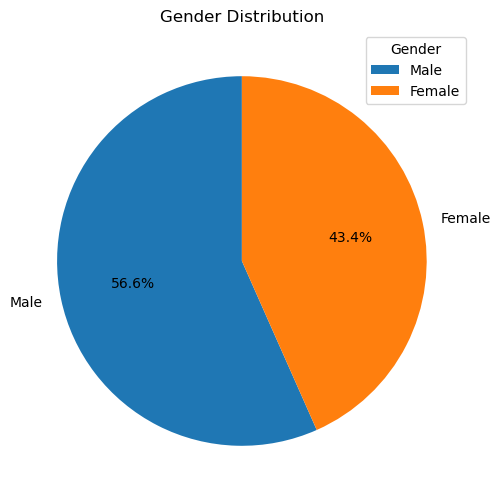

In [15]:
genders = df1['Gender'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(genders, labels=genders.index, autopct='%1.1f%%', startangle=90)
plt.title("Gender Distribution")
plt.legend(title="Gender", loc="best")
plt.show()


---

### Age Distribution


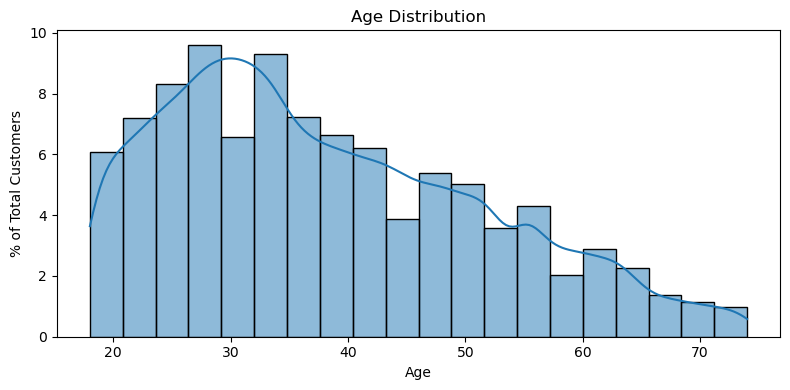

In [16]:
plt.figure(figsize=(8, 4))
sns.histplot(data=df1, x='Age', bins=20, kde=True, stat='percent')
plt.title("Age Distribution")
plt.ylabel("% of Total Customers")
plt.xlabel("Age")
plt.tight_layout()
plt.show()


---

### Customer Country Distribution


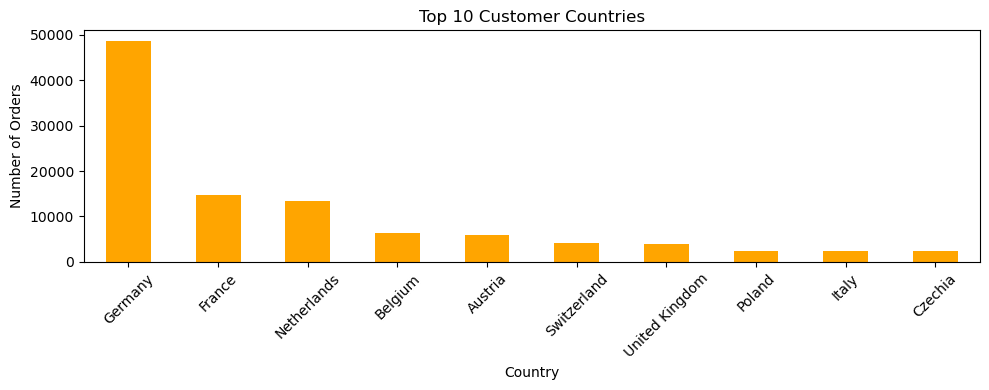

In [17]:
top_countries = df1['Customer_Country'].value_counts().head(10)

plt.figure(figsize=(10, 4))
top_countries.plot(kind='bar', color='orange')
plt.title("Top 10 Customer Countries")
plt.xlabel("Country")
plt.ylabel("Number of Orders")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


---

###  Review Score Distribution by Gender


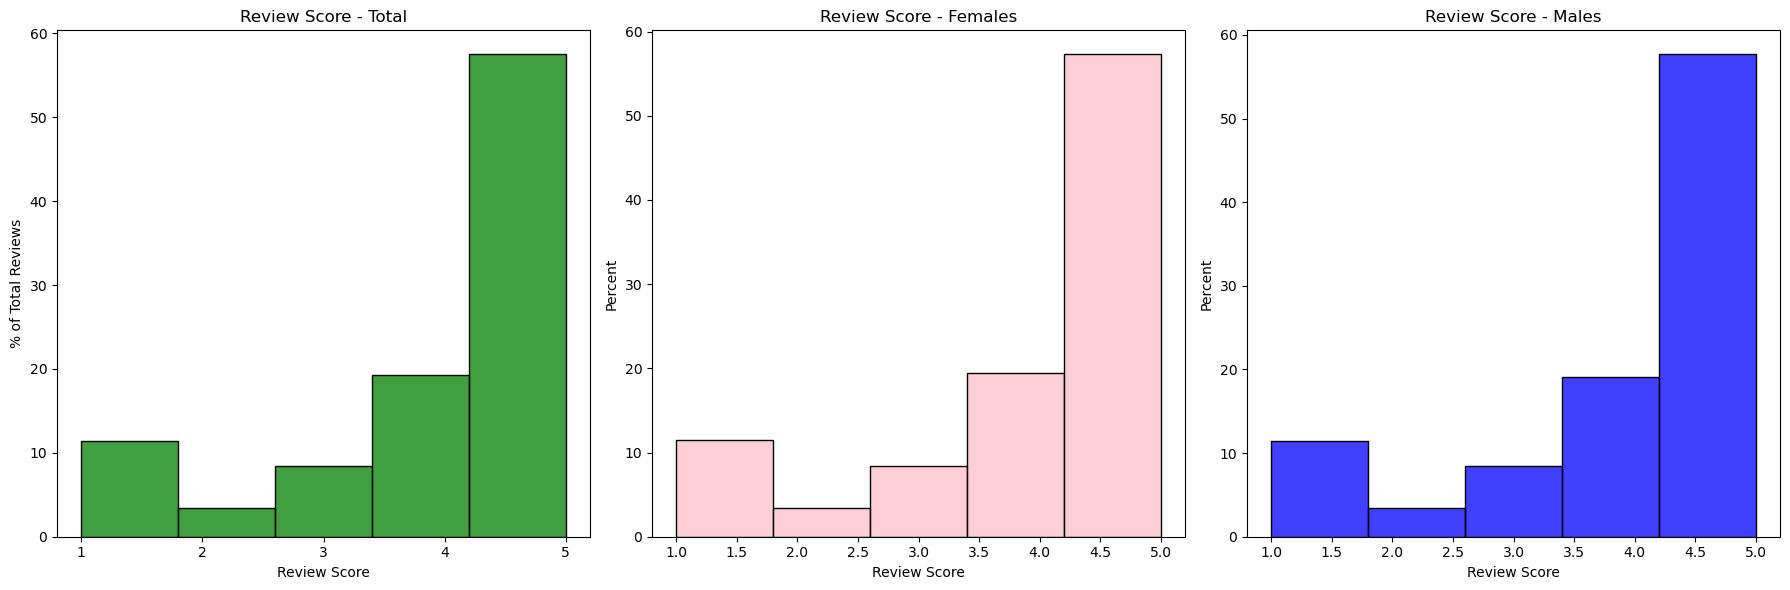

In [171]:
plt.figure(figsize=(18, 6))

# Total
plt.subplot(1, 3, 1)
sns.histplot(df1['Review_Score'], bins=5, kde=False, color='green', stat='percent')
plt.xticks([1, 2, 3, 4, 5])
plt.title("Review Score - Total")
plt.xlabel("Review Score")
plt.ylabel("% of Total Reviews")

# Female
plt.subplot(1, 3, 2)
sns.histplot(df1[df1['Gender'] == 'Female']['Review_Score'], bins=5, kde=False, color='pink', stat='percent')
plt.title("Review Score - Females")
plt.xlabel("Review Score")

# Male
plt.subplot(1, 3, 3)
sns.histplot(df1[df1['Gender'] == 'Male']['Review_Score'], bins=5, kde=False, color='blue', stat='percent')
plt.title("Review Score - Males")
plt.xlabel("Review Score")

plt.tight_layout()
plt.show()


---

### Review Score vs. Gender (Boxplot)


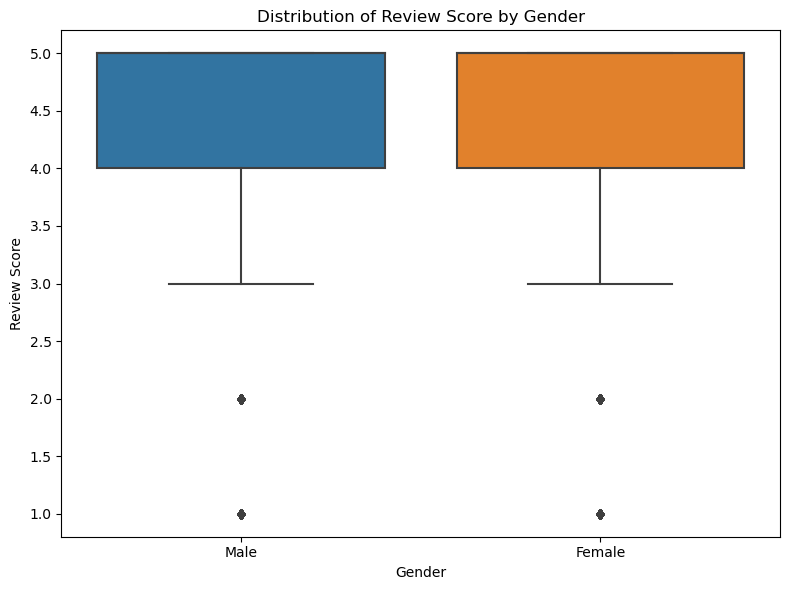

Average Review Score by Gender:
Gender
Female    4.077606
Male      4.082608
Name: Review_Score, dtype: float64


In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df1, x='Gender', y='Review_Score')
plt.title('Distribution of Review Score by Gender')
plt.ylabel('Review Score')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

# Print average review scores by gender
average_scores = df1.groupby('Gender')['Review_Score'].mean()
print("Average Review Score by Gender:")
print(average_scores)


By observing the boxplots divided by gender for the review scores, we confirm that the average customer rating is very high, but there does not appear to be a visible difference in ratings between genders. In fact, looking at the numerical averages, they are practically the same: males gave an average rating of 4.036175, while females gave an average of 4.021721.

In [20]:
df1.describe()

,Age,Price,Freight_Value,Product_Weight_Gr,Product_Length_Cm,Product_Height_Cm,Product_Width_Cm,Review_Score,Payment_Value,Is_late,Has_left_review,Delivery_Time_Days,Avg_delivery_time,Package_Volume
count,114857.000000,114857.000000,114857.000000,114857.000000,114857.000000,114857.000000,114857.000000,114857.000000,114857.000000,114857.000000,114857.0,114857.000000,114857.000000,114857.000000
mean,38.263719,119.770566,19.974517,2103.298110,30.226055,16.571389,23.058699,4.080439,171.254042,0.064123,1.0,12.422273,12.422273,15271.560802
std,13.415836,181.425093,15.703468,3769.214289,16.111515,13.416409,11.726057,1.347679,263.766598,0.244973,0.0,9.422248,4.350717,23400.593082
min,18.000000,0.850000,0.000000,0.000000,7.000000,2.000000,6.000000,1.000000,0.000000,0.000000,1.0,0.000000,2.000000,168.000000
25%,28.000000,39.900000,13.080000,300.000000,18.000000,8.000000,15.000000,4.000000,60.720000,0.000000,1.0,7.000000,7.898638,2856.000000
50%,36.000000,74.900000,16.280000,700.000000,25.000000,13.000000,20.000000,5.000000,108.000000,0.000000,1.0,10.000000,12.240772,6561.000000
75%,48.000000,132.900000,21.150000,1800.000000,38.000000,20.000000,30.000000,5.000000,188.690000,0.000000,1.0,16.000000,16.010956,18375.000000
max,74.000000,6735.000000,409.680000,40425.000000,105.000000,105.000000,118.000000,5.000000,13664.080000,1.000000,1.0,209.000000,139.000000,296208.000000


---

### Correlation Analysis

We explore how numeric features relate to each other and to review scores.


Text(0.5, 1.0, 'Correlation Matrix')

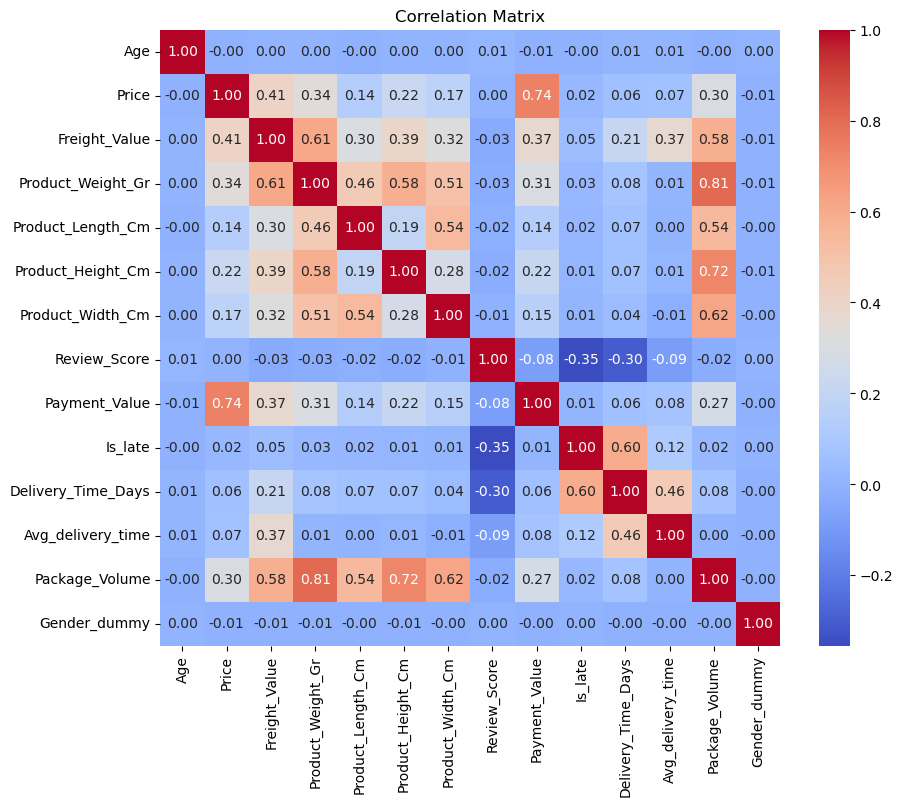

In [21]:
#Encoding of categorical variables
df1['Gender_dummy'] = df1['Gender'].map({'Male': 1, 'Female': 0})
 
correlation = df1.drop(columns=['Has_left_review', 'Gave_Low_Score']).corr(numeric_only=True)

plt.figure(figsize=(10,8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlation Matrix')


This heatmap shows relationships between numeric features.

- `Is_late` and `Delivery_Time_Days` are **negatively correlated** with `Review_Score`, suggesting late or long deliveries lead to lower scores.
- Strong correlations among product dimensions and volume.
- `Payment_Value` is closely tied to `Price`.

These insights support our feature selection for modeling.


In [22]:
seller_dummies = pd.get_dummies(df1['Seller_Country'], prefix='Seller')
customer_dummies = pd.get_dummies(df1['Customer_Country'], prefix='Customer')
categories_dummies = pd.get_dummies(df1['Product_Category_Name'], prefix='Product_Cat')
df1 = pd.concat([df1, seller_dummies, customer_dummies, categories_dummies], axis=1)

## Hypothesis Testing

We perform statistical tests to examine differences in review scores based on gender, delivery timing, and customer age.


In [23]:
from scipy.stats import ttest_ind, spearmanr

# T-test: Male vs Female
male_scores = df1[df1['Gender'] == 'Male']['Review_Score']
female_scores = df1[df1['Gender'] == 'Female']['Review_Score']

t_stat, p_value = ttest_ind(male_scores, female_scores, nan_policy='omit')
print(f"T-test (Male vs Female): t={t_stat:.2f}, p={p_value:.4f}")

# T-test: Late vs On-time
late_scores = df1[df1['Is_late'] == 1]['Review_Score']
on_time_scores = df1[df1['Is_late'] == 0]['Review_Score']

t_stat, p_value = ttest_ind(late_scores, on_time_scores, nan_policy='omit')
print(f"T-test (Late vs On-time): t={t_stat:.2f}, p={p_value:.4f}")

# Spearman correlation: Age vs Review Score
corr, p_value = spearmanr(df1['Age'], df1['Review_Score'])
print(f"Spearman Correlation: r = {corr:.4f}, p = {p_value:.4f}")


T-test (Male vs Female): t=0.62, p=0.5330
T-test (Late vs On-time): t=-128.60, p=0.0000
Spearman Correlation: r = 0.0131, p = 0.0000



**Gender**: No significant difference between male and female review scores  

**Delivery timing**: A strong significant difference exists  **late deliveries receive lower scores**

**Age**: Weak but statistically significant positive correlation with review score  

## Modeling

This section covers **classification** (predicting review score class). Several models are evaluated and compared.

### Features Used
We selected a mix of numerical and categorical variables that are likely to influence customer review scores:


In [137]:
features = ['Gender_dummy','Package_Volume', 'Age', 'Is_late', 'Delivery_Time_Days',
    'Avg_delivery_time', 'Product_Weight_Gr', 'Freight_Value',  'Payment_Value', 'Seller_Country', 'Customer_Country', 'Product_Category_Name']
target = 'Review_Class'

In [138]:
cat_features = ['Seller_Country', 'Customer_Country', 'Product_Category_Name']
num_features = ['Gender_dummy', 'Is_late', 'Delivery_Time_Days','Package_Volume', 'Age', 'Freight_Value', 'Product_Weight_Gr', 'Avg_delivery_time']

### Preprocessing
- Numerical features are standardized using `StandardScaler`
- Categorical features are one-hot encoded using `OneHotEncoder`

In [139]:
# transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])


### Train/Validation/Test Split
The labeled data is split as follows:
- **80% training set**
- **10% validation set**
- **10% test set**

Stratified splitting is used to preserve class distribution of `Review_Class` across all subsets.

In [140]:
# Feature matrix and target
X = df1[features]
y = df1[target]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train (80%) and Temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)

Train shape: (91885, 12)
Validation shape: (11486, 12)
Test shape: (11486, 12)


In [141]:
np.bincount(y_train)

array([70552, 13613,  7720])

## Logistic Regression with SMOTE

To address class imbalance in the `Review_Class` target, we use a pipeline that includes:

- **Preprocessing**: scaling numeric and one-hot encoding categorical features
- **SMOTE**: synthetic minority over-sampling to balance class distributions in the training set
- **Logistic Regression**: a simple, interpretable classification model


In [147]:
# scale + classify
logreg_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=1000))
])

logreg_pipeline.fit(X_train, y_train)

y_val_pred = logreg_pipeline.predict(X_val)

print("Logistic Regression - Validation Set Performance:")
print(classification_report(y_val, y_val_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Logistic Regression - Validation Set Performance:
              precision    recall  f1-score   support

           0       0.83      0.61      0.70      8819
           1       0.41      0.35      0.38      1702
           2       0.10      0.39      0.16       965

    accuracy                           0.55     11486
   macro avg       0.45      0.45      0.41     11486
weighted avg       0.71      0.55      0.61     11486

Confusion Matrix:
[[5357  704 2758]
 [ 614  593  495]
 [ 454  138  373]]


### Validation Results
The model was evaluated on the validation set, with the following performance:

- **Accuracy**: 55%
- **Macro F1-score**: 0.41
- **Weighted F1-score**: 0.61
##### Class-wise performance:
- **Class 0 (High)**: Precision 0.83, Recall 0.61 — strong but not perfect
- **Class 1 (Low)**: Moderate precision and recall
- **Class 2 (Medium)**: Low precision but **improved recall (0.39)** due to SMOTE
##### Confusion Matrix Highlights:
- The model confuses many class 0 and class 2 samples
- **SMOTE helped improve recall for the underrepresented Medium class**, but overall accuracy dropped as a trade-off

This model demonstrates that while oversampling can help balance recall, logistic regression may not capture the complexity of the data as well as tree-based models.

## Random Forest with SMOTE

To improve classification performance on underrepresented classes, we use a pipeline combining:

- **Preprocessing**: scaling and one-hot encoding
- **SMOTE**: synthetic over-sampling to balance classes in the training set
- **Random Forest**: a robust ensemble model that handles complex relationships and non-linearity



In [148]:
smote = SMOTE(random_state=42)
rf_balanced = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', RandomForestClassifier(
        n_estimators=100, 
        class_weight=None,
        random_state=42))
])

rf_balanced.fit(X_train, y_train)
y_val_bal = rf_balanced.predict(X_val)

print("Balanced RF - Validation Performance:")
print(classification_report(y_val, y_val_bal))
print(confusion_matrix(y_val, y_val_bal))


Balanced RF - Validation Performance:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      8819
           1       0.66      0.56      0.60      1702
           2       0.45      0.24      0.32       965

    accuracy                           0.81     11486
   macro avg       0.66      0.58      0.60     11486
weighted avg       0.79      0.81      0.80     11486

[[8169  412  238]
 [ 696  956   50]
 [ 638   91  236]]


### Validation Results

- **Accuracy**: 81%
- **Macro F1-score**: 0.60
- **Weighted F1-score**: 0.80

##### Class-wise Performance:
- **Class 0 (High reviews)**: Excellent — F1 = 0.89, Recall = 93%
- **Class 1 (Low reviews)**: Decent — F1 = 0.60, Recall = 56%
- **Class 2 (Medium reviews)**: Noticeable improvement — Recall = 24%, F1 = 0.32

##### Confusion Matrix Insights
- Most Medium-class predictions are still confused with High and Low
- SMOTE improves the recall for both Low and Medium, without harming High
- Better overall class balance than with Logistic Regression

This model strikes a solid balance between overall accuracy and recall improvement for minority classes, making it a strong candidate for the final model.

## Random Forest Hyperparameter Tuning (RandomizedSearchCV)

To optimize our Random Forest model, we applied **RandomizedSearchCV** over a wide parameter grid, including:

- `n_estimators`: number of trees
- `max_depth`: maximum tree depth
- `min_samples_split`: minimum samples to split a node
- `min_samples_leaf`: minimum samples in leaf nodes
- `max_features`: number of features considered at each split
- `bootstrap`: whether bootstrapping is used

We used:
- `n_iter=30` for 30 random combinations
- `f1_weighted` as the scoring metric
- 3-fold cross-validation


In [150]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [10, 20, 30, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2', None],
    'classifier__bootstrap': [True, False]
}
random_search = RandomizedSearchCV(
    estimator=rf_balanced,
    param_distributions=param_grid,
    n_iter=30,  # Try 30 combinations
    scoring='f1_weighted',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)
best_rf_model = random_search.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time= 5.2min
[CV] END classifier__bootstrap=False, classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=200; total time= 5.2min
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=50; total time=  28.1s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=10, classifier__n_estimators=50; total time=  27.7s
[CV] END classifier__bootstrap=False, classifier__max_depth=20, classifier__max_features=sqrt, cl

/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time= 1.4min
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=50; total time= 1.4min
[CV] END classifier__bootstrap=False, classifier__max_depth=30, classifier__max_features=log2, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=100; total time= 1.1min
[CV] END classifier__bootstrap=False, classifier__max_depth=10, classifier__max_features=sqrt, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=  27.0s
[CV] END classifier__bootstrap=True, classifier__max_depth=10, classifier__max_features=None, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifie

In [151]:
y_val_pred = best_rf_model.predict(X_val)

print("Validation Set Performance (RandomizedSearchCV):")
print(classification_report(y_val, y_val_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))


Validation Set Performance (RandomizedSearchCV):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      8819
           1       0.70      0.54      0.61      1702
           2       0.52      0.22      0.31       965

    accuracy                           0.83     11486
   macro avg       0.69      0.57      0.61     11486
weighted avg       0.80      0.83      0.81     11486

Confusion Matrix:
[[8344  327  148]
 [ 727  923   52]
 [ 683   65  217]]


### Validation Results

- **Accuracy**: 83%
- **Macro F1-score**: 0.61
- **Weighted F1-score**: 0.81

#### Class-wise Performance:
- **Class 0 (High reviews)**: Excellent — F1 = 0.90, Recall = 95%
- **Class 1 (Low reviews)**: Solid — F1 = 0.61, Recall = 54%
- **Class 2 (Medium reviews)**: Best so far — F1 = 0.31, Recall = 22%

### Insights
- This tuned model performs better than previous versions, especially on Low and Medium classes.
- The gain in **recall** and **F1 for Medium** is a key success from SMOTE + tuning.
- It maintains very high accuracy on the dominant High class.

This model is a strong candidate for final deployment or business use.

##  Top Feature Importances (Random Forest)

The chart below shows the five most important features identified by the final Random Forest model.

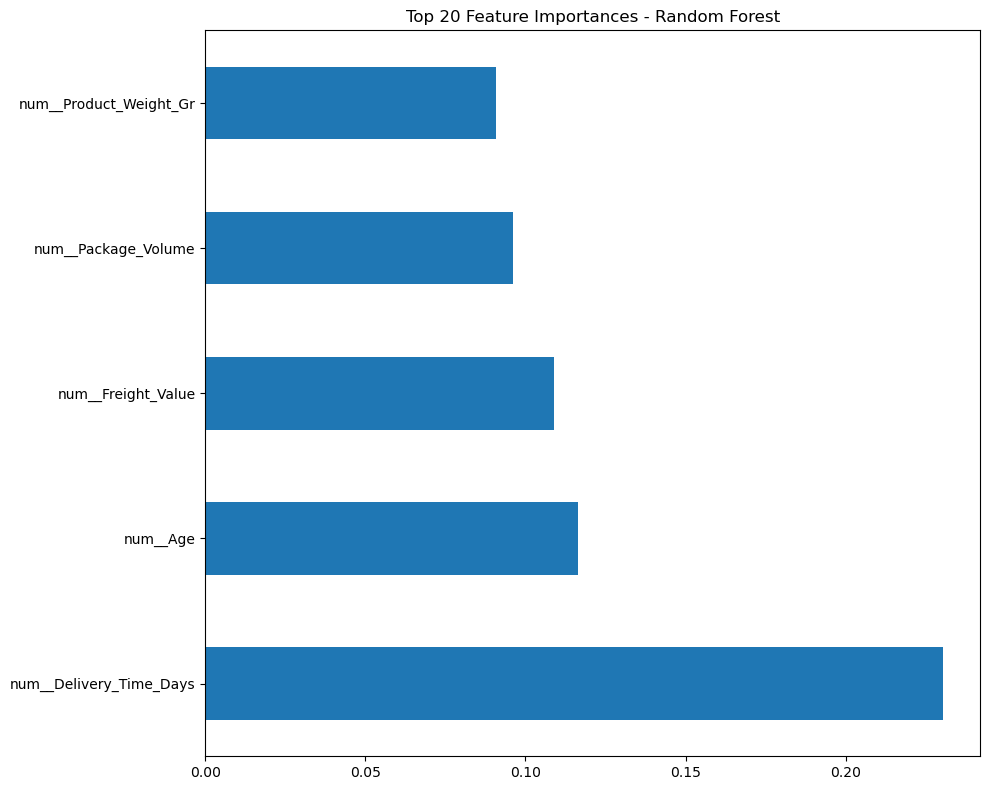

In [152]:
importances = best_rf_model.named_steps['classifier'].feature_importances_

feature_names = best_rf_model.named_steps['preprocessor'].get_feature_names_out()
feat_importances = pd.Series(importances, index=feature_names)

feat_importances.nlargest(5).plot(kind='barh', figsize=(10, 8))
plt.title("Top 20 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

- **Delivery time (`Delivery_Time_Days`)** is by far the most influential factor in predicting review scores.
- Other notable contributors include **Age**, **Freight Value**, and **Package Volume**.

## XGBoost with SMOTE

We applied SMOTE to balance class distribution and trained an XGBoost classifier with tuned parameters.


In [156]:
xgb_pipeline = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote),
    ('classifier', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ))
])

xgb_pipeline.fit(X_train, y_train)

y_val_pred = xgb_pipeline.predict(X_val)

print("XGBoost - Validation Set Performance:")
print(classification_report(y_val, y_val_pred, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:17:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - Validation Set Performance:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      8819
           1       0.54      0.36      0.43      1702
           2       0.16      0.09      0.12       965

    accuracy                           0.76     11486
   macro avg       0.51      0.45      0.47     11486
weighted avg       0.72      0.76      0.73     11486

Confusion Matrix:
[[8013  423  383]
 [1025  613   64]
 [ 784   93   88]]


### Validation Results
- **Accuracy**: 76%
- **Macro F1-score**: 0.47
- **Weighted F1-score**: 0.73

- Class 0 (High): F1 = 0.86 → strong
- Class 1 (Low): F1 = 0.43 → moderate
- Class 2 (Medium): F1 = 0.12 → weak

Despite balancing with SMOTE, XGBoost underperforms on the Medium class compared to Random Forest.

## Tuned XGBoost with SMOTE (RandomizedSearchCV)

We optimized XGBoost using `RandomizedSearchCV` over a wide hyperparameter grid with 20 combinations and 3-fold stratified cross-validation.


In [159]:
param_grid_xgboost = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [4, 6, 8],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 1],
    'classifier__colsample_bytree': [0.8, 1],
    'classifier__scale_pos_weight': [1, 2, 5]
}

In [160]:
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=param_grid_xgboost,
    n_iter=20,  # number of combinations to try
    scoring='f1_weighted',
    n_jobs=-1,
    cv=cv_strategy,
    verbose=2,
    random_state=42
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_

y_val_pred = best_model.predict(X_val)
print("Best XGBoost - Validation Set Performance:")
print(classification_report(y_val, y_val_pred, target_names=label_encoder.classes_, zero_division=0))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: User

[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time= 1.3min
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time= 1.3min


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=6, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time= 1.4min
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time= 1.5min
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time= 1.5min


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time= 1.6min


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:23:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  15.1s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=0.8; total time= 1.8min


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  13.7s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=0.8; total time= 1.8min


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  35.2s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  14.4s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  33.8s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  11.9s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  11.7s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  11.4s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1;

/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=0.8; total time=  11.0s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=0.8; total time=  15.9s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=0.8; total time=  18.3s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: User

[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  22.5s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  23.0s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=100, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  24.3s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=100, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  27.4s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=100, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  28.8s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=8, classifier__n_estimators=100, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  29.6s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  14.1s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  14.6s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:24:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=6, classifier__n_estimators=100, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  14.5s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  14.3s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  44.1s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  43.8s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  14.3s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.01, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  43.5s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.1, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  14.2s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=0.8; total time=  37.2s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  14.5s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=0.8; total time=  38.0s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=0.8; total time=  36.9s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  15.4s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=1; total time=  15.3s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: User

[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  29.6s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  29.7s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=100, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  21.7s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=100, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  21.7s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=1; total time=  29.7s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:25:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: User

[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=0.8; total time=  34.5s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=0.8; total time=  34.3s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=200, classifier__scale_pos_weight=2, classifier__subsample=0.8; total time=  34.1s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:26:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:26:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:26:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  16.0s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=8, classifier__n_estimators=100, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  21.1s


/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:26:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  14.6s
[CV] END classifier__colsample_bytree=1, classifier__learning_rate=0.05, classifier__max_depth=4, classifier__n_estimators=200, classifier__scale_pos_weight=5, classifier__subsample=0.8; total time=  14.7s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=0.8; total time=  25.0s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier__subsample=0.8; total time=  24.6s
[CV] END classifier__colsample_bytree=0.8, classifier__learning_rate=0.01, classifier__max_depth=6, classifier__n_estimators=200, classifier__scale_pos_weight=1, classifier

/Users/goudarzimandanagmail.com/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:26:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost - Validation Set Performance:
              precision    recall  f1-score   support

        High       0.82      0.92      0.87      8819
         Low       0.55      0.39      0.46      1702
      Medium       0.21      0.08      0.11       965

    accuracy                           0.77     11486
   macro avg       0.53      0.46      0.48     11486
weighted avg       0.73      0.77      0.74     11486

Confusion Matrix:
[[8147  435  237]
 [1004  658   40]
 [ 798   93   74]]


### Validation Results
- **Accuracy**: 77%
- **Macro F1-score**: 0.48
- **Weighted F1-score**: 0.74

##### Class-wise Performance:
- **High**: F1 = 0.87 (strong)
- **Low**: F1 = 0.46 (moderate)
- **Medium**: F1 = 0.11 (very weak)

Despite tuning, XGBoost still struggles with the **Medium** class, confirming that Random Forest may be better suited for this task in our dataset.

## Final Model Evaluation on Test Set (Random Forest)

We evaluated the best-performing Random Forest model (with SMOTE and hyperparameter tuning) on the test set.

In [163]:
y_test_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))


              precision    recall  f1-score   support

           0       0.86      0.95      0.90      8819
           1       0.70      0.55      0.61      1702
           2       0.52      0.25      0.34       965

    accuracy                           0.83     11486
   macro avg       0.69      0.58      0.62     11486
weighted avg       0.81      0.83      0.81     11486

[[8337  317  165]
 [ 716  934   52]
 [ 642   85  238]]


### Test Set Results
- **Accuracy**: 83%
- **Macro F1-score**: 0.62
- **Weighted F1-score**: 0.81

##### Class-wise Performance:
- **High**: F1 = 0.90 (excellent)
- **Low**: F1 = 0.61 (solid)
- **Medium**: F1 = 0.34 (improved but still limited)

The model maintains strong performance across all classes and generalizes well from validation to test data, confirming its robustness and reliability.


## Anomaly Detection on Review Behavior

In this final step, we use **Isolation Forest** to identify outliers in review behavior. These anomalies may represent:
- Extremely low or high scores in unexpected situations
- Potential data errors or exceptional service failures

We apply the method to selected numeric features influencing customer satisfaction.

In [165]:
anomaly_features = df1[[
    'Review_Score',
    'Is_late',
    'Delivery_Time_Days',
    'Avg_delivery_time',
    'Payment_Value',
    'Package_Volume',
    'Product_Weight_Gr'
]]

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
df1['anomaly'] = iso_forest.fit_predict(anomaly_features)

# Anomaly label: -1 = outlier, 1 = normal
anomaly_counts = df1['anomaly'].value_counts()
print("Anomaly counts:\n", anomaly_counts)


Anomaly counts:
  1    113708
-1      1149
Name: anomaly, dtype: int64


In [168]:
df1[df1['anomaly'] == -1][[
    'Review_Score', 'Is_late', 'Delivery_Time_Days', 
    'Avg_delivery_time', 'Payment_Value'
]].sample(10)


,Review_Score,Is_late,Delivery_Time_Days,Avg_delivery_time,Payment_Value
50966,5,1,187,29.266667,255.04
3383,1,1,31,7.898638,117.69
13046,5,0,4,12.790827,2314.82
32527,4,0,3,7.898638,1797.73
88351,1,1,28,15.653846,543.29
101871,3,1,40,16.010956,320.39
77418,1,1,45,24.773519,386.00
110109,5,0,11,15.695652,1155.56
109585,1,1,42,16.010956,279.17
105226,1,0,10,12.790827,1421.69


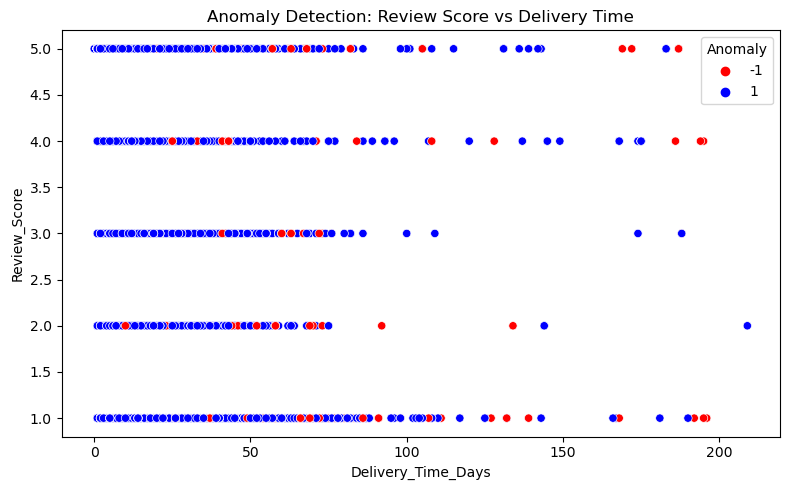

In [166]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df1,
    x='Delivery_Time_Days',
    y='Review_Score',
    hue='anomaly',
    palette={1: 'blue', -1: 'red'}
)
plt.title('Anomaly Detection: Review Score vs Delivery Time')
plt.legend(title='Anomaly')
plt.tight_layout()
plt.show()


### Key Observations:
- Most reviews follow expected patterns: short delivery → high score
- Red dots highlight anomalies, such as:
  - Very long delivery times with high scores
  - Very short deliveries with unexpectedly low scores

These may indicate data errors, inconsistent customer behavior, or exceptional service cases worth further analysis.
